In [1]:
library(dplyr)
library(tidyverse)
library(VIM)
library(faraway)
library(ggplot2)
library(naniar)
library(GGally)
library(caret)
library(fastDummies)
library(leaps)
library(recipes)
library(rstan)
library(tree)
library(bayesplot)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.1     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attaching package: 'VIM'


The f

## Background
403 African Americans were interviewed in a study to understand the prevalence of obesity, diabetes, and other cardiovascular risk factors in central Virginia. Glycosolated hemoglobin (glyhb) greater than 7.0 is usually taken as a positive diagnosis of diabetes. We are interested in identifying the most important predicotrs that contribute to a high glyhb level in african american patience while also creating a predictive model that accurately identifies patience with diabetes. 


### Questions to answer:
- How much ades Age, Sex, and Location impact the glyhb levels in patients
- Are there any interaction effects between waist, height, and hip that could explain glyhb levels.

In [2]:
head(diabetes)

,id,chol,stab.glu,hdl,ratio,glyhb,location,age,gender,height,weight,frame,bp.1s,bp.1d,bp.2s,bp.2d,waist,hip,time.ppn
,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>,<int>,<fct>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1000,203,82,56,3.6,4.31,Buckingham,46,female,62,121,medium,118,59,NA,NA,29,38,720
2,1001,165,97,24,6.9,4.44,Buckingham,29,female,64,218,large,112,68,NA,NA,46,48,360
3,1002,228,92,37,6.2,4.64,Buckingham,58,female,61,256,large,190,92,185,92,49,57,180
4,1003,78,93,12,6.5,4.63,Buckingham,67,male,67,119,large,110,50,NA,NA,33,38,480
5,1005,249,90,28,8.9,7.72,Buckingham,64,male,68,183,medium,138,80,NA,NA,44,41,300
6,1008,248,94,69,3.6,4.81,Buckingham,34,male,71,190,large,132,86,NA,NA,36,42,195


In [3]:
summary(diabetes)

       id             chol          stab.glu          hdl        
 Min.   : 1000   Min.   : 78.0   Min.   : 48.0   Min.   : 12.00  
 1st Qu.: 4792   1st Qu.:179.0   1st Qu.: 81.0   1st Qu.: 38.00  
 Median :15766   Median :204.0   Median : 89.0   Median : 46.00  
 Mean   :15978   Mean   :207.8   Mean   :106.7   Mean   : 50.45  
 3rd Qu.:20336   3rd Qu.:230.0   3rd Qu.:106.0   3rd Qu.: 59.00  
 Max.   :41756   Max.   :443.0   Max.   :385.0   Max.   :120.00  
                 NA's   :1                       NA's   :1       
     ratio            glyhb             location        age           gender   
 Min.   : 1.500   Min.   : 2.68   Buckingham:200   Min.   :19.00   male  :169  
 1st Qu.: 3.200   1st Qu.: 4.38   Louisa    :203   1st Qu.:34.00   female:234  
 Median : 4.200   Median : 4.84                    Median :45.00               
 Mean   : 4.522   Mean   : 5.59                    Mean   :46.85               
 3rd Qu.: 5.400   3rd Qu.: 5.60                    3rd Qu.:60.00        

In [4]:
table(diabetes$diabetesT)

< table of extent 0 >

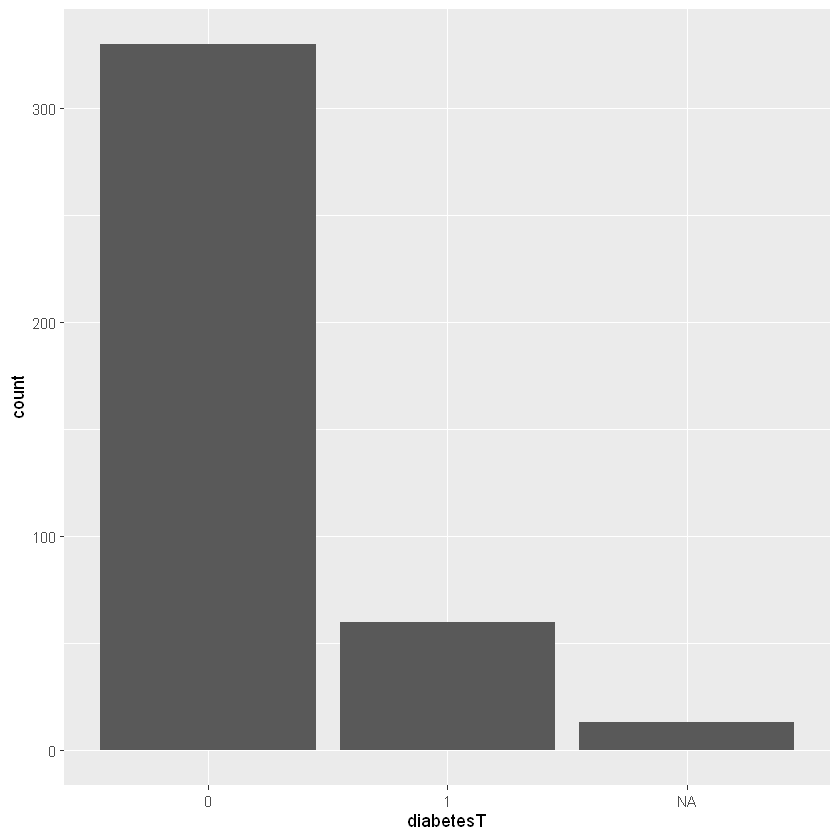

In [5]:
diabetes$diabetesT <- as.factor(ifelse(diabetes$glyhb >= 7, 1, 0))
ggplot(data = diabetes, mapping = aes(x= diabetesT)) + 
geom_bar()


In [6]:
stab.gender.gplot <- ggplot(data= diabetes, mapping = aes(x=gender, y= stab.glu)) + geom_boxplot() + facet_wrap(~location) + labs(
    x = "Gender",
    y = "Stable Glucose Level",
    title = "Glucose Level by Gender and Location"
    
)
ggsave("StabGlucoseLevelGenderLocation.png", plot = stab.gender.gplot, width = 8, height = 6)

Don't know how to automatically pick scale for object of type <labelled>. Defaulting to continuous.


In [7]:
plot <- ggplot(data = diabetes, mapping = aes(x = gender, y = glyhb)) +
  geom_boxplot() +
  facet_wrap(~location) +
  labs(
    x = "Gender",
    y = "GLYHB Level",
    title = "GLYHB Level by Gender and Location"
  )

ggsave("GLYHBLevelGenderLocation.png", plot = plot, width = 8, height = 6)


Don't know how to automatically pick scale for object of type <labelled>. Defaulting to continuous.
Warning message:
"Removed 13 rows containing non-finite outside the scale range (`stat_boxplot()`)."


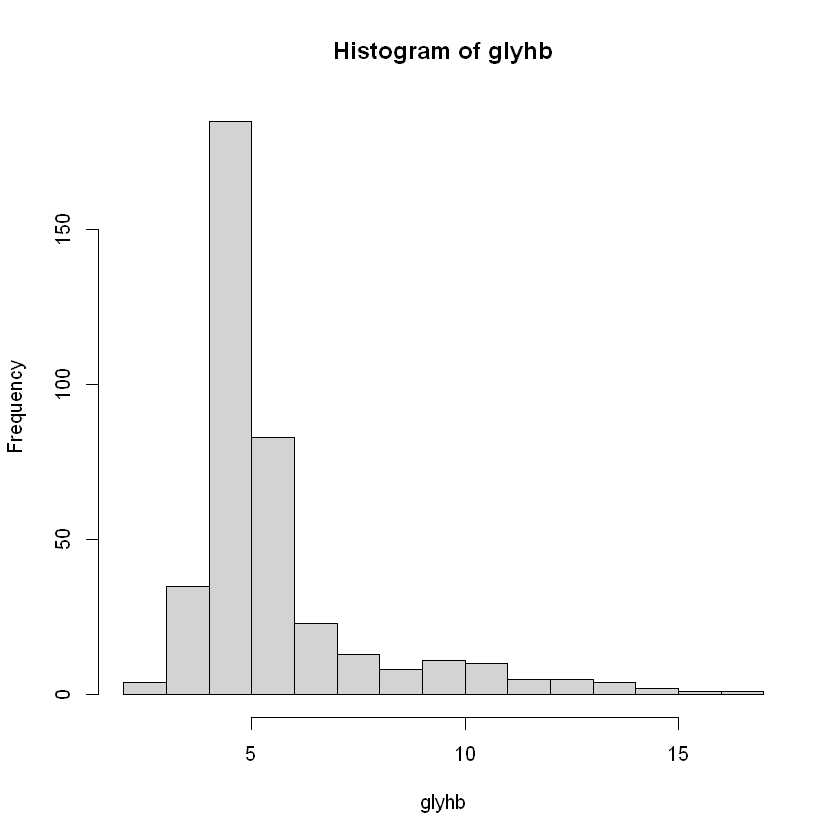

In [8]:
hist(diabetes$glyhb, main="Histogram of glyhb", xlab="glyhb") 

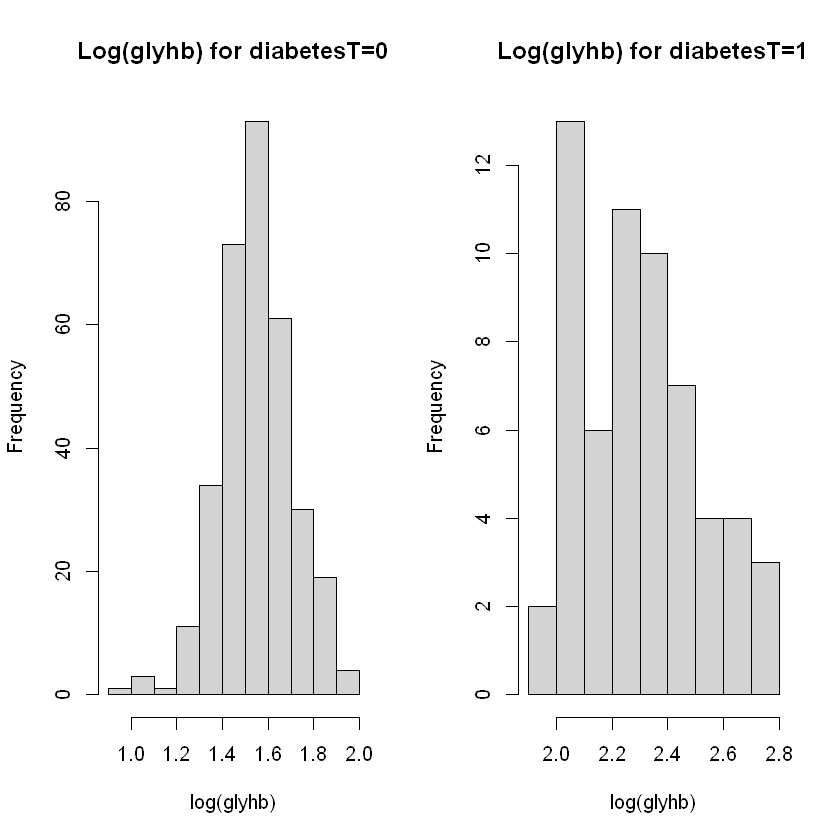

In [9]:
par(mfrow=c(1,2)) 
split_data <- split(log(diabetes$glyhb), diabetes$diabetesT)
hist(split_data[[1]], main="Log(glyhb) for diabetesT=0", xlab="log(glyhb)")
hist(split_data[[2]], main="Log(glyhb) for diabetesT=1", xlab="log(glyhb)")

Don't know how to automatically pick scale for object of type <labelled>. Defaulting to continuous.
Don't know how to automatically pick scale for object of type <labelled>. Defaulting to continuous.
Warning message:
"Removed 13 rows containing missing values or values outside the scale range (`geom_point()`)."


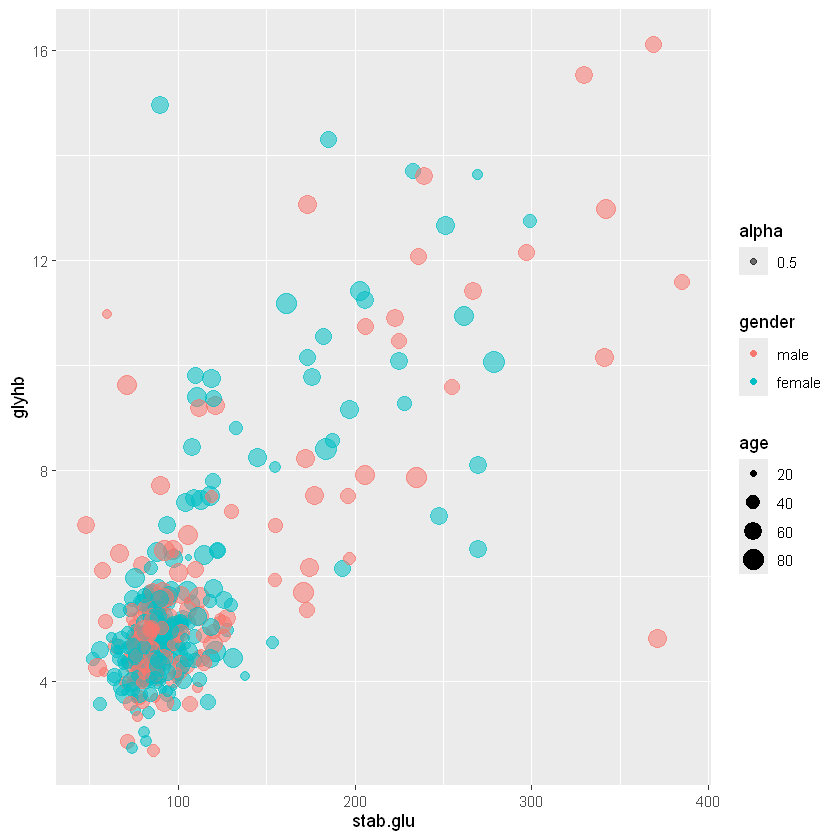

In [66]:
ggplot(data = diabetes, mapping = aes(x=stab.glu, y=glyhb, alpha = 0.5)) + geom_point(aes(size = age, color = gender))

In [94]:
glyhb.stab.scatter <- ggplot(data = diabetes, mapping = aes(x= age, y = log(glyhb))) + geom_point(aes(size = as.numeric(ratio), colour = as.numeric(stab.glu),alpha = 0.5)) + scale_colour_binned() +
facet_wrap(~gender) + labs(x="Age", y="GLYHB", title = "GLYHB age comparison", caption = "Those who are older, tend to have a higher glyhb level with a combination of stab glucose and high ratio") 

ggsave("GLYHBLevelGenderAgeStabGlu.png", plot = glyhb.stab.scatter, width = 8, height = 6)

Don't know how to automatically pick scale for object of type <labelled>. Defaulting to continuous.
Warning message:
"Removed 14 rows containing missing values or values outside the scale range (`geom_point()`)."


In [92]:
scatter.glyhb <- ggplot(data = diabetes, mapping = aes(x=waist, y=glyhb, size = as.numeric(stab.glu), colour = location, alpha = 0.5)) + geom_point() + facet_wrap(~gender)
ggsave("GLYHBLevelGenderLocationScatter.png", plot = scatter.glyhb, width = 8, height = 6)

Don't know how to automatically pick scale for object of type <labelled>. Defaulting to continuous.
Warning message:
"Removed 15 rows containing missing values or values outside the scale range (`geom_point()`)."


## Correlation Analysis

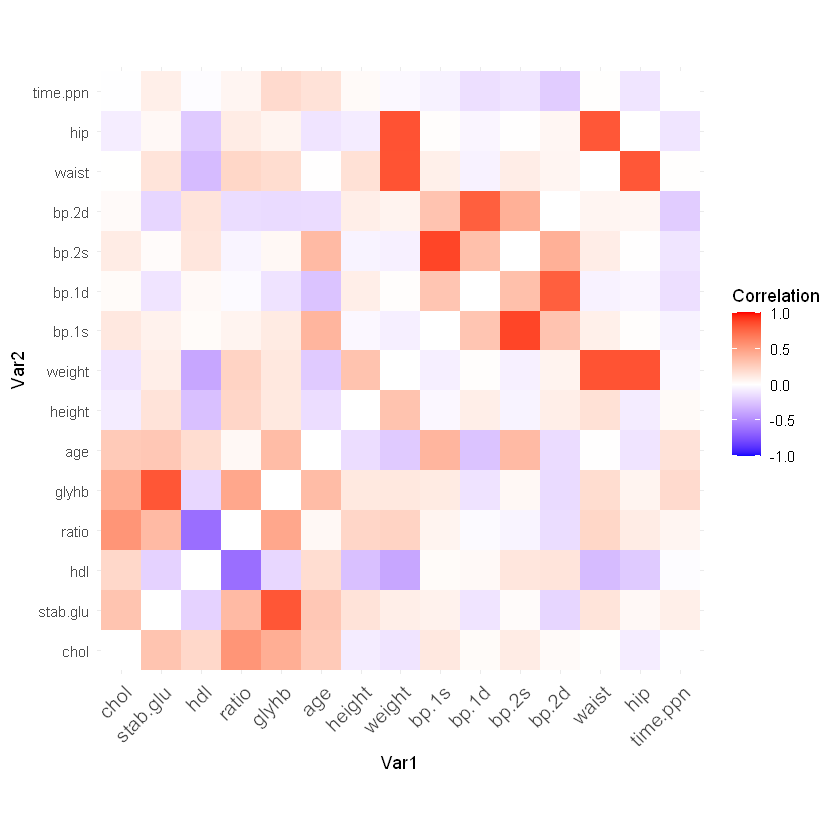

In [10]:
diabetes_clean <- diabetes %>% 
  dplyr::select(-c(id, location, gender, frame, diabetesT)) %>% 
  filter(complete.cases(.))

cor_matrix <- cor(diabetes_clean)
diag(cor_matrix) <- 0 
cor_data <- as.data.frame(as.table(cor_matrix))

ggplot(cor_data, aes(Var1, Var2, fill = Freq)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
                       midpoint = 0, limit = c(-1, 1), space = "Lab", 
                       name="Correlation") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, 
                                   size = 12, hjust = 1)) +
  coord_fixed()

In [11]:
diabetes_clean_T <- diabetes %>% 
  filter(diabetesT == 1) %>%
  dplyr::select(-c(id, location, gender, frame, diabetesT)) %>% 
  filter(complete.cases(.))

cor_matrix_T <- cor(diabetes_clean_T)
diag(cor_matrix_T) <- 0 
cor_data_T <- as.data.frame(as.table(cor_matrix_T))

diabetes_clean_F <- diabetes %>% 
  filter(diabetesT == 0) %>%
  dplyr::select(-c(id, location, gender, frame, diabetesT)) %>% 
  filter(complete.cases(.))

cor_matrix_F <- cor(diabetes_clean_F)
diag(cor_matrix_F) <- 0 
cor_data_F <- as.data.frame(as.table(cor_matrix_F))

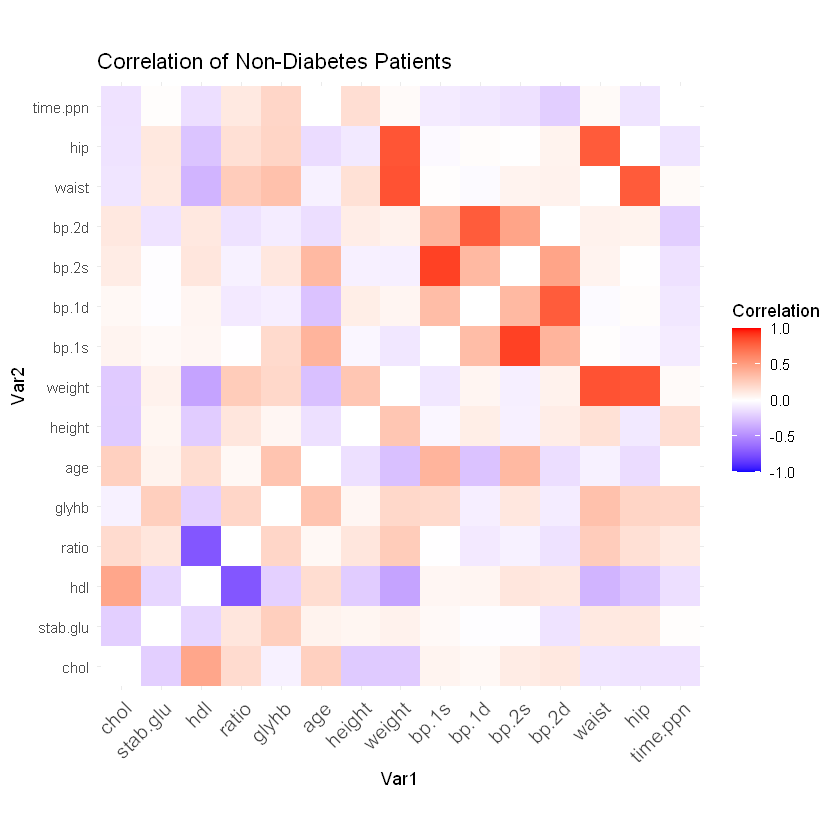

In [12]:
ggplot(cor_data_F, aes(Var1, Var2, fill = Freq)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
                       midpoint = 0, limit = c(-1, 1), space = "Lab", 
                       name="Correlation") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, 
                                   size = 12, hjust = 1)) +
  coord_fixed() +
  ggtitle("Correlation of Non-Diabetes Patients")

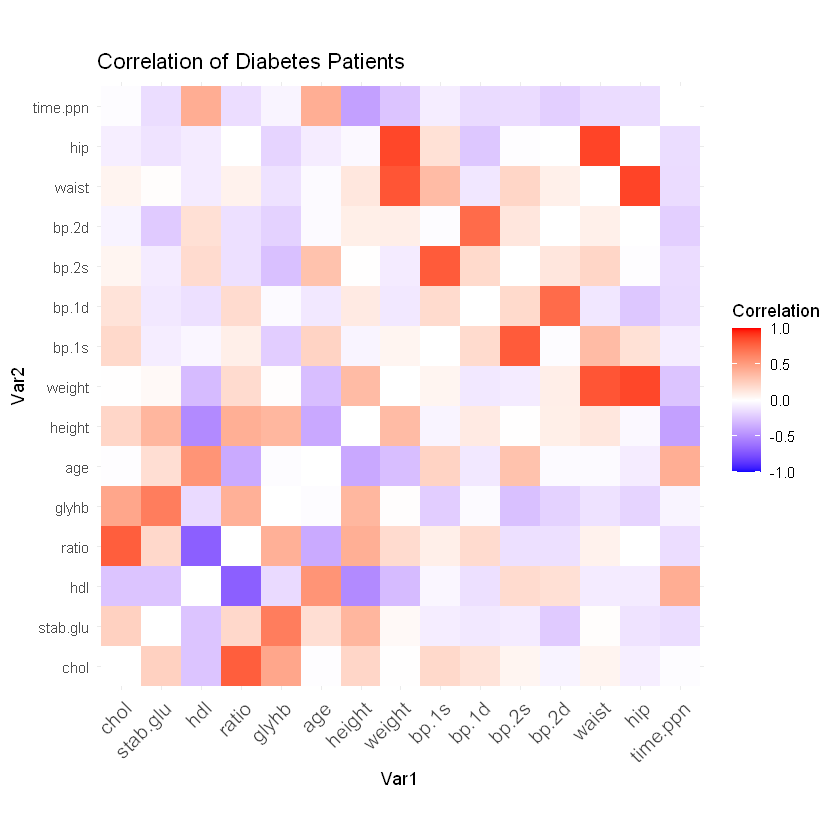

In [13]:
par(mfrow=c(1,2))

ggplot(cor_data_T, aes(Var1, Var2, fill = Freq)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
                       midpoint = 0, limit = c(-1, 1), space = "Lab", 
                       name="Correlation") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, 
                                   size = 12, hjust = 1)) +
  coord_fixed() +
  ggtitle("Correlation of Diabetes Patients")

## Pre-Process

In [10]:
diabetes %>% summarise(across(everything(),~sum(is.na(.)))) %>% select(where(~ . > 0))

chol,hdl,ratio,glyhb,height,weight,frame,bp.1s,bp.1d,bp.2s,bp.2d,waist,hip,time.ppn,diabetesT
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,1,13,5,1,12,5,5,262,262,2,2,3,13


In [11]:
diabetes.drop <- diabetes %>% filter(!is.na(glyhb)) %>% dplyr::select(-c(diabetesT, id))

In [12]:
X <- subset(diabetes.drop, select = -c(glyhb)) #%>% dummy_columns(remove_first_dummy = T, remove_selected_columns = T, ignore_na = T)
y <- log(diabetes.drop$glyhb)

In [13]:
recipe <- recipe(~ ., data = X) %>%
  step_impute_knn(all_predictors()) %>% 
  step_normalize(all_numeric_predictors())  %>%
  step_dummy(all_factor_predictors())

In [14]:
prepared_recipe <- prep(recipe)
diabetes.clean <- bake(prepared_recipe, new_data = NULL)

chol,stab.glu,hdl,ratio,age,height,weight,bp.1s,bp.1d,bp.2s,bp.2d,waist,hip,time.ppn,location_Louisa,gender_female,frame_medium,frame_large
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.09393653,-0.4709910,0.3301899,-0.5307872,-0.04711384,-1.0108656,-1.3939480,-0.8298859,-1.7896547,-0.461453967,-1.94732913,-1.5476112,-0.8932065,1.24223986,0,1,1,0
-0.94435765,-0.1921712,-1.5210095,1.3679372,-1.08143433,-0.4995328,1.0071563,-1.0916725,-1.1254178,0.602259647,-0.55173241,1.4076487,0.8813760,0.07438816,0,1,0,1
0.46555105,-0.2851111,-0.7689597,0.9651774,0.68299474,-1.2665320,1.9477951,2.3115533,0.6458805,2.463758472,0.08262974,1.9291652,2.4785002,-0.50953769,0,1,0,1
-2.89137443,-0.2665231,-2.2152092,1.1377888,1.23057617,0.2674664,-1.4434553,-1.1789347,-2.4538916,-0.394971866,-0.55173241,-0.8522560,-0.8932065,0.46367206,0,0,0,1
0.93552062,-0.3222871,-1.2896095,2.5186790,1.04804903,0.5231328,0.1407785,0.0427361,-0.2397687,0.003920739,-0.67860484,1.0599711,-0.3608318,-0.12025379,0,0,1,0
0.91314111,-0.2479351,1.0822396,-0.5307872,-0.77722242,1.2901320,0.3140540,-0.2190505,0.2030559,-0.062561362,0.59011945,-0.3307395,-0.1833735,-0.46087720,0,0,0,1


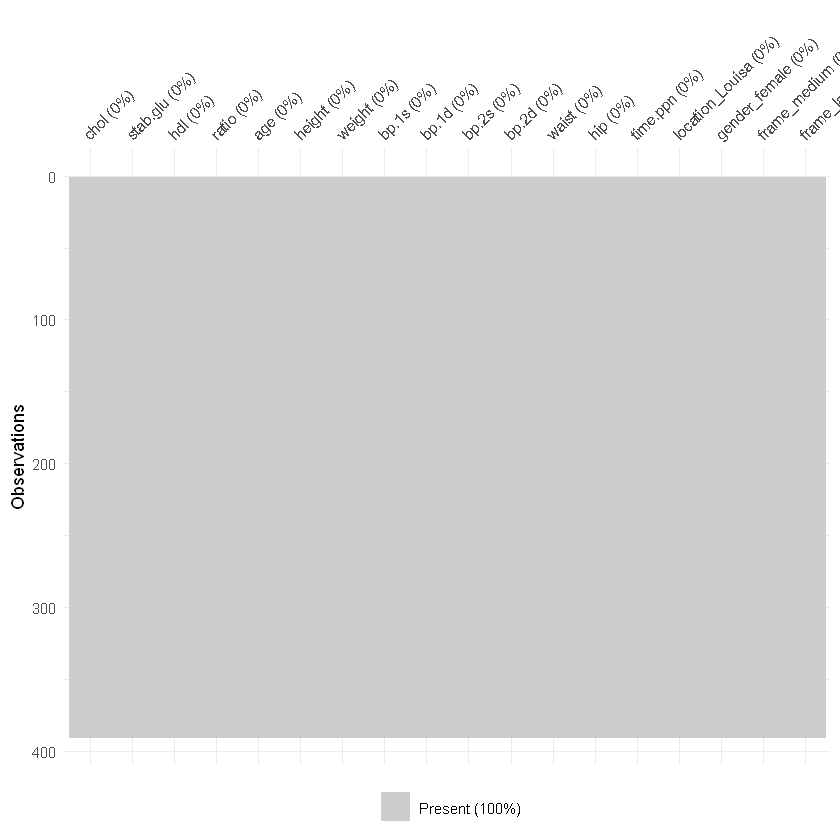

In [15]:
vis_miss(diabetes.clean)
head(diabetes.clean)

## Regression  Model

In [16]:
set.seed(42)
train.indx <- createDataPartition(y = y, p = .8, list = FALSE)

In [17]:
X.train <-diabetes.clean[train.indx,]
X.test <- diabetes.clean[-train.indx,]

y.train <- y[train.indx] 
y.test <- y[-train.indx]

Xy.train <- cbind(X.train, y.train)
Xy.test <- cbind(X.test, y.test)

In [18]:
linear.model <- lm(y.train~., data = Xy.train)

In [19]:
summary(linear.model)


Call:
lm(formula = y.train ~ ., data = Xy.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.97412 -0.11028 -0.01357  0.09243  1.09316 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      1.671134   0.041306  40.458  < 2e-16 ***
chol             0.026645   0.024169   1.102  0.27116    
stab.glu         0.183913   0.012788  14.381  < 2e-16 ***
hdl             -0.012552   0.028770  -0.436  0.66295    
ratio            0.024986   0.031278   0.799  0.42502    
age              0.046953   0.016209   2.897  0.00405 ** 
height           0.008738   0.018892   0.463  0.64404    
weight          -0.015397   0.034045  -0.452  0.65142    
bp.1s            0.029869   0.021923   1.362  0.17408    
bp.1d           -0.012647   0.018407  -0.687  0.49260    
bp.2s           -0.020080   0.018543  -1.083  0.27974    
bp.2d           -0.002283   0.016608  -0.137  0.89075    
waist            0.029838   0.027855   1.071  0.28495    
hip              0.

In [109]:
y.hat.lin <- predict(linear.model, X.test)
exp(sqrt(mean((y.hat.lin-y.test)^2)))

[1] 1.229018

In [101]:
linear.model.interactions <- lm(y.train~stab.glu + age + time.ppn + bp.1d*chol+ gender_female, data = Xy.train)

In [102]:
interactions <- model.matrix(~(.)^2-1, data = X.train)

In [103]:
subset.model <- summary(regsubsets(x = interactions, y= y.train, method = "backward"))

Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"1  linear dependencies found"


In [27]:
c(selected.variables,"stab.glu", "gender_female", "location_Louisa", "waist", "bp.1s", "frame_medium")

ERROR: Error: object 'selected.variables' not found


In [96]:
dim(interactions)

[1] 314 171

In [104]:
best.model.index <- which.max(subset.model$adjr2)

best.model.variables <- colnames(interactions)[subset.model$which[best.model.index,]]

print(best.model.variables)

selected.variables <- best.model.variables

X.train.selected <- interactions[, c(selected.variables), drop = FALSE]#,"stab.glu", "gender_female", "location_Louisa", "waist", "bp.1s", "frame_medium"), drop = FALSE]

final.model <- lm(y.train ~ . ,data = as.data.frame(X.train.selected))

summary(final.model)

[1] "chol"                     "height"                  
[3] "stab.glu:bp.1s"           "stab.glu:waist"          
[5] "stab.glu:time.ppn"        "stab.glu:location_Louisa"
[7] "stab.glu:gender_female"   "stab.glu:frame_medium"   
[9] "hip:location_Louisa"     



Call:
lm(formula = y.train ~ ., data = as.data.frame(X.train.selected))

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8743 -0.1277 -0.0230  0.1103  1.1406 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 1.662646   0.013660 121.714  < 2e-16 ***
chol                        0.042475   0.013320   3.189 0.001577 ** 
height                     -0.006659   0.013492  -0.494 0.621976    
`stab.glu:bp.1s`           -0.009713   0.017469  -0.556 0.578606    
`stab.glu:waist`            0.036527   0.014794   2.469 0.014098 *  
`stab.glu:time.ppn`         0.051216   0.015415   3.323 0.001001 ** 
`stab.glu:location_Louisa`  0.125668   0.019391   6.481 3.68e-10 ***
`stab.glu:gender_female`    0.148304   0.024341   6.093 3.35e-09 ***
`stab.glu:frame_medium`     0.096956   0.025557   3.794 0.000179 ***
`hip:location_Louisa`       0.014707   0.019818   0.742 0.458620    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.

Gender and Stable Glucose: Females with higher stable glucose levels have significantly higher glyhb levels compared to males, suggesting a stronger relationship between stable glucose and glyhb for females.

Location (Louisa): People in Louisa generally have lower glyhb levels, regardless of stable glucose levels.

Stable Glucose (Overall): Stable glucose is a strong predictor of glyhb levels, significantly increasing glyhb irrespective of gender or location.

Chol: Higher Higher glucose levels overall effect the glyhb levels by 1.03 units when all other vraibales are kept constant.

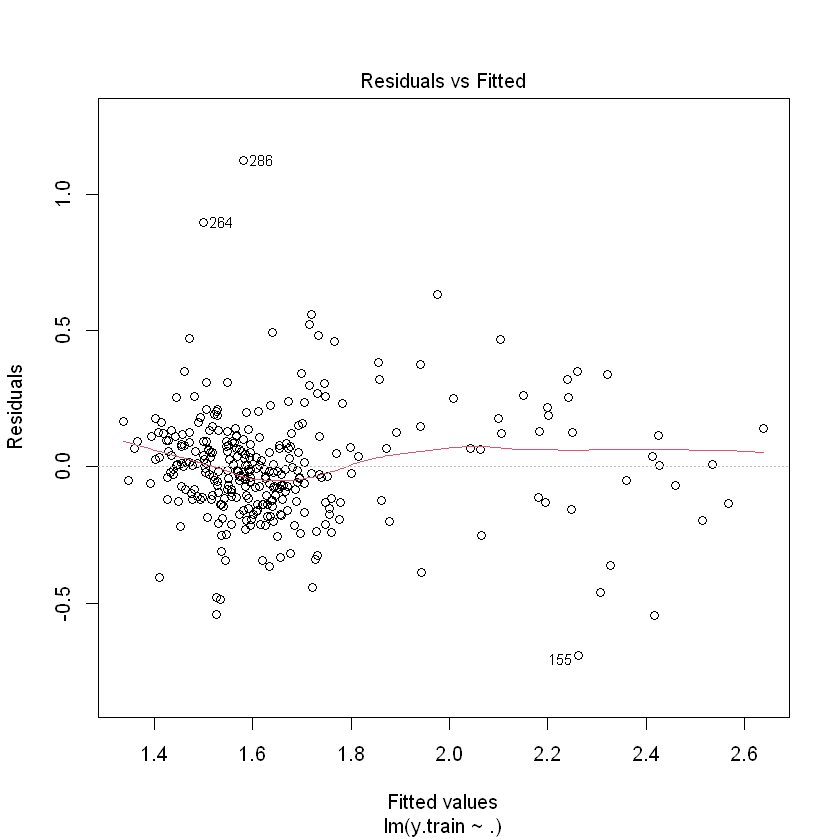

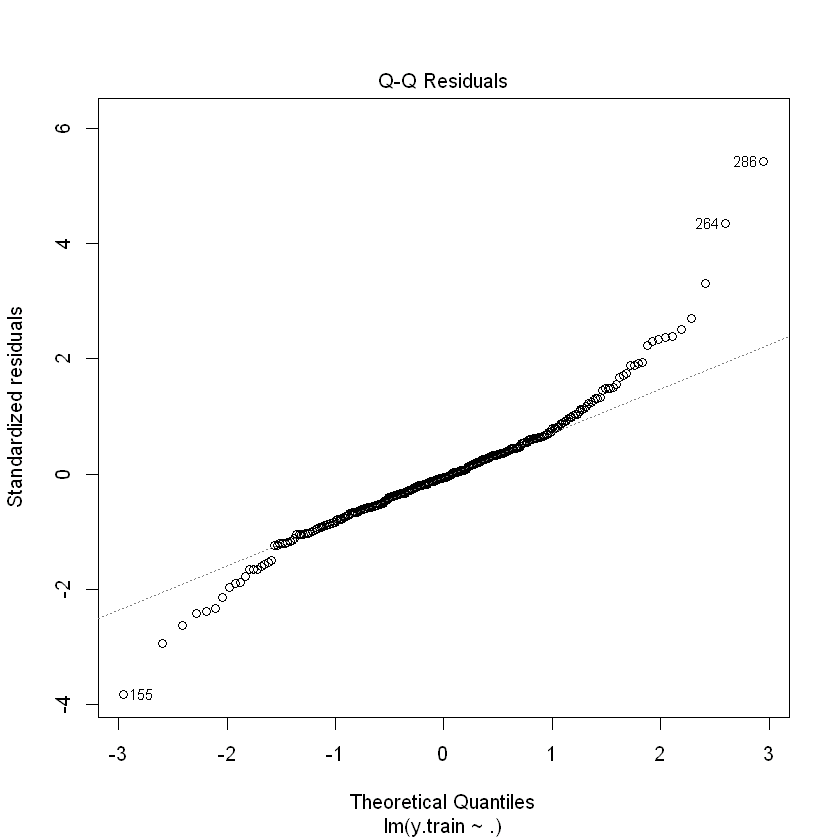

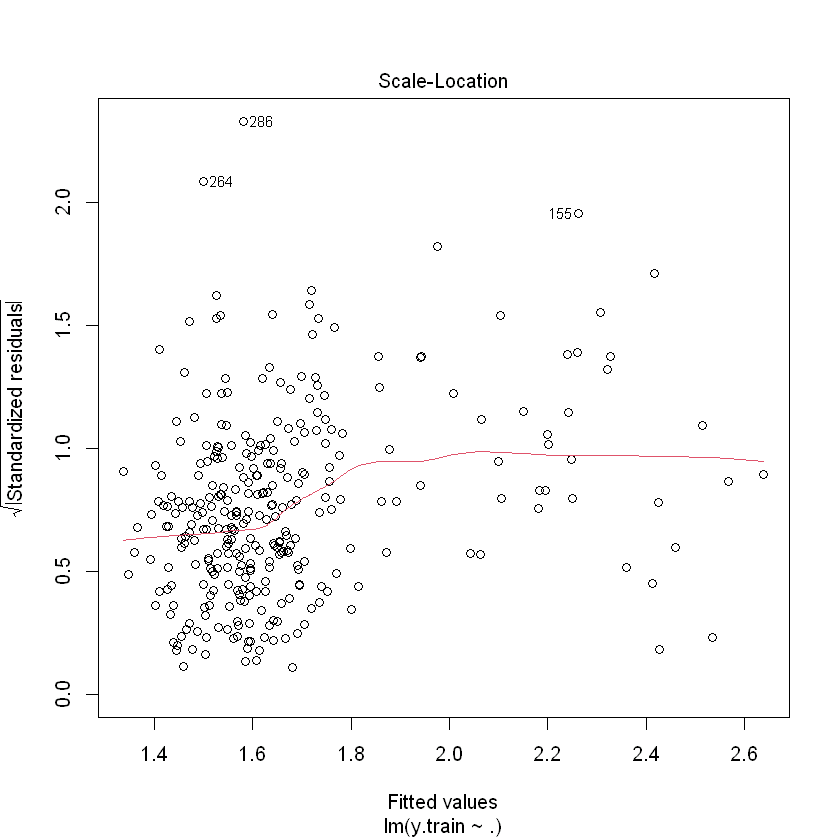

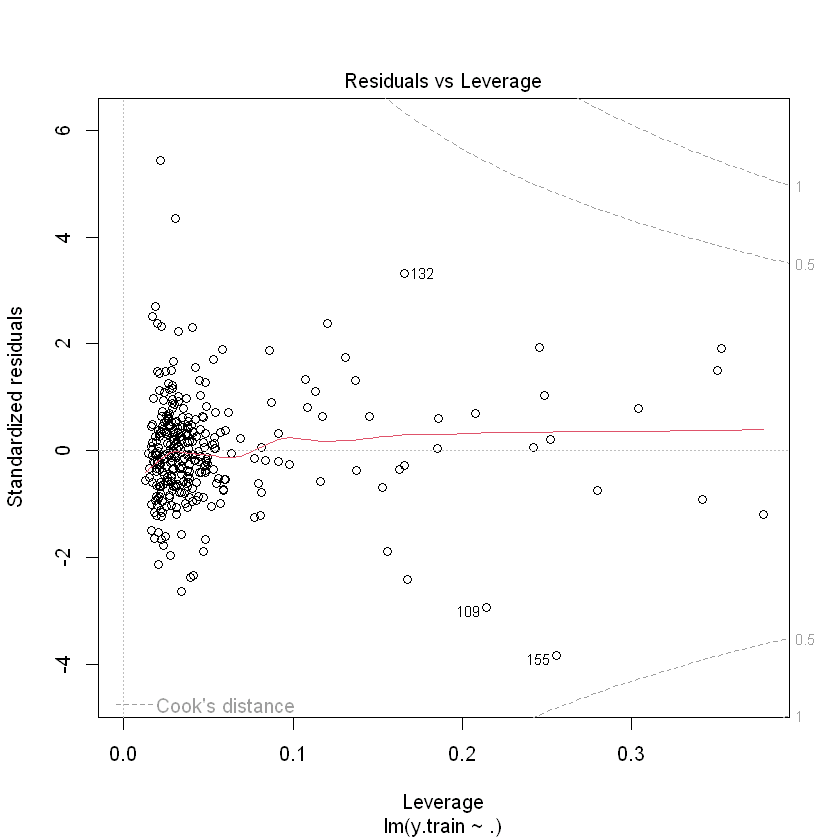

In [29]:
plot(final.model)

In [30]:
interactions.test <- model.matrix(~(.)^2-1, data = X.test)

X.test.selected <- as.data.frame(interactions.test[, c(selected.variables,"stab.glu", "gender_female", "location_Louisa", "waist", "bp.1s", "frame_medium"), drop = FALSE])

In [110]:
y.hat <- predict(final.model, X.test.selected)
exp(sqrt(mean((y.hat - y.test)^2)))

[1] 1.280351

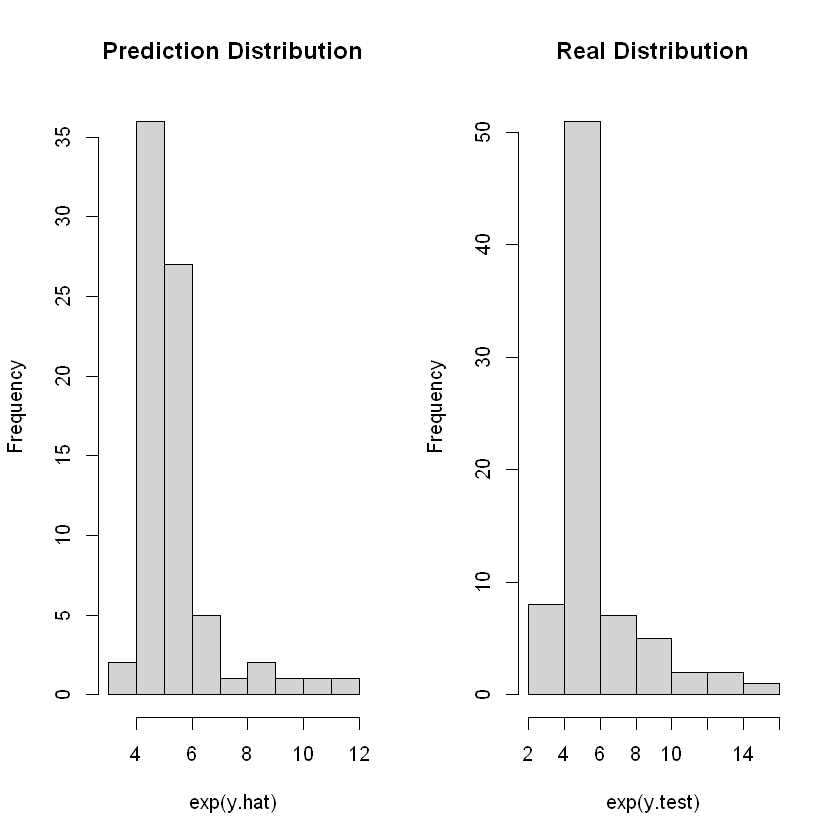

In [32]:
par(mfrow=c(1,2))
hist(exp(y.hat), main = "Prediction Distribution")
hist(exp(y.test), main = "Real Distribution")

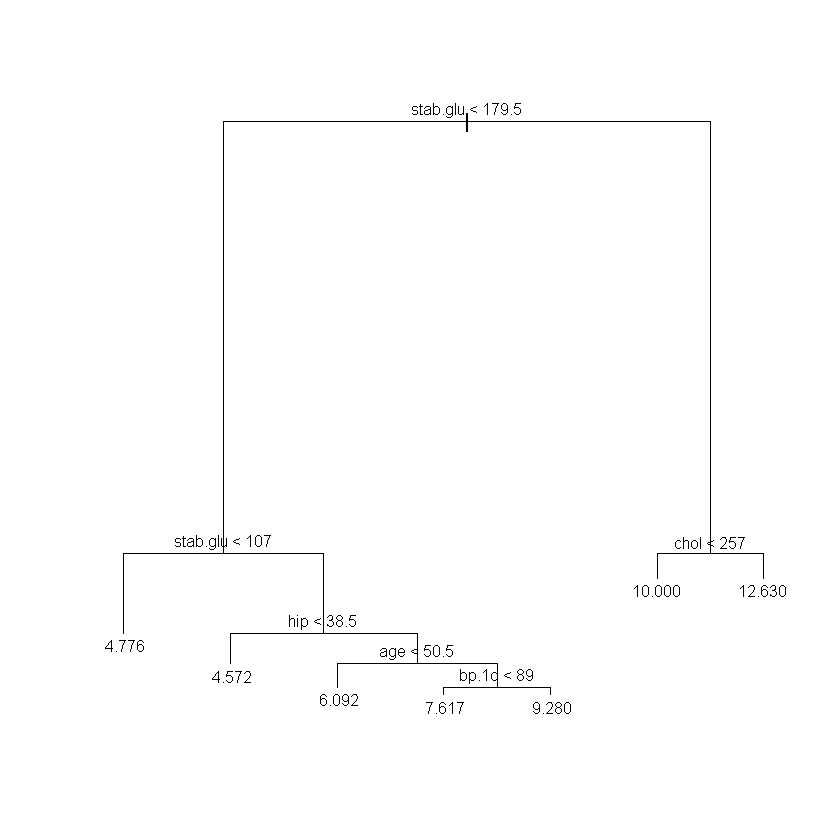

In [33]:
plot(tree(exp(y)~.,data=X))
text(tree(exp(y)~.,data=X), pretty = 3, cex = 0.8)

## Bayesian Regression

In [34]:
model = stan_model("gpriorLM.stan")

In [36]:
model

S4 class stanmodel 'anon_model' coded as follows:
data {
  int<lower=0> N; // Number of observations
  int<lower=0> K; // Number of predictors
  real<lower=0> g; // g prior
  real<lower=0> nu0; // Prior degrees of freedom
  real<lower=0> s20; // Prior sigma^2
  matrix[N, K] X; // Data matrix
  vector[N] y; // Response variable
}
parameters {
  vector[K] beta; // Regression coefficients
  real<lower=0> sigma; // Residual standard deviation
}
transformed parameters {
  matrix[N, N] Hg; // Hat matrix
  real SSRg; // Residual Sum of Squares under g-prior
  vector[K] betaOLS; // Ordinary least squares estimator for beta
  // Compute Hat matrix
  Hg = X * inverse(X' * X) * X';
  // Compute SSRg
  SSRg = dot_self(y - Hg * y); // Efficient computation of quadratic form
  // Compute betaOLS
  betaOLS = inverse(X' * X) * (X' * y);
}
model {
  // Priors
  sigma ~ inv_gamma((nu0 + N) / 2, (nu0 * s20 + SSRg) / 2); // Prior on sigma
  beta ~ multi_normal((g / (g + 1)) * betaOLS, square(sigma) * (g /

### Model Test

In [52]:
set.seed(123)  # For reproducibility
N <- 100    # Number of observations
K <- 5      # Number of predictors
beta_true <- c(3, -2, 1, 0, 0)  # True coefficients (including zeroes for sparsity)
sigma_true <- 1.5  # True residual standard deviation

X.s <- matrix(rnorm(N * K, mean = 0, sd = 1), nrow = N, ncol = K)

y.s <- X.s %*% beta_true + rnorm(N, mean = 0, sd = sigma_true)

s20 <- mean((y.s - X.s %*% solve(t(X.s) %*% X.s) %*% t(X.s) %*% y.s )^2)
s20

[1] 1.827968

In [53]:
mod1_data <- list(
  X = X.s,
  K = ncol(X.s),
  N = nrow(X.s),
  y = as.vector(y.s),
  g = nrow(X.s),
  nu0 = 1,
  s20 = s20
)

In [54]:
fit = sampling(model, mod1_data,chains=4)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000178 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.78 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.296 seconds (Warm-up)
Chain 1:                1.378 seconds (Sampling)
Chain 1:                2.6

In [55]:
beta_true

[1]  3 -2  1  0  0

In [75]:
posterior_means <- summary(fit)$summary[, "mean"]  
beta_means <- posterior_means[grep("^beta", rownames(summary(fit)$summary))]

comparison <- data.frame(
  True = beta_true,
  Estimated = beta_means
)
print(comparison)

posterior_summary <- summary(fit)$summary
beta_credible <- posterior_summary[grep("^beta", rownames(posterior_summary)), c("2.5%", "97.5%")]

In [78]:
# Combine for comparison
credible_check <- data.frame(
  True = beta_true,
  lower = beta_credible[, "2.5%"],
  upper = beta_credible[, "97.5%"]
)
credible_check$InInterval <- with(credible_check, True >= lower & True <= upper)
print(credible_check)

           True       lower       upper InInterval
beta[1]       3  2.74392156  3.18150601       TRUE
beta[2]      -2 -1.98182935 -1.55516930      FALSE
beta[3]       1  0.78507749  1.21719006       TRUE
beta[4]       0 -0.31529775  0.07662868       TRUE
beta[5]       0  0.09241711  0.51499244      FALSE
betaOLS[1]    3  2.97538082  2.97538082      FALSE
betaOLS[2]   -2 -1.77904499 -1.77904499      FALSE
betaOLS[3]    1  1.00878106  1.00878106      FALSE
betaOLS[4]    0 -0.12328900 -0.12328900      FALSE
betaOLS[5]    0  0.30736867  0.30736867      FALSE


In [57]:
params = extract(fit)

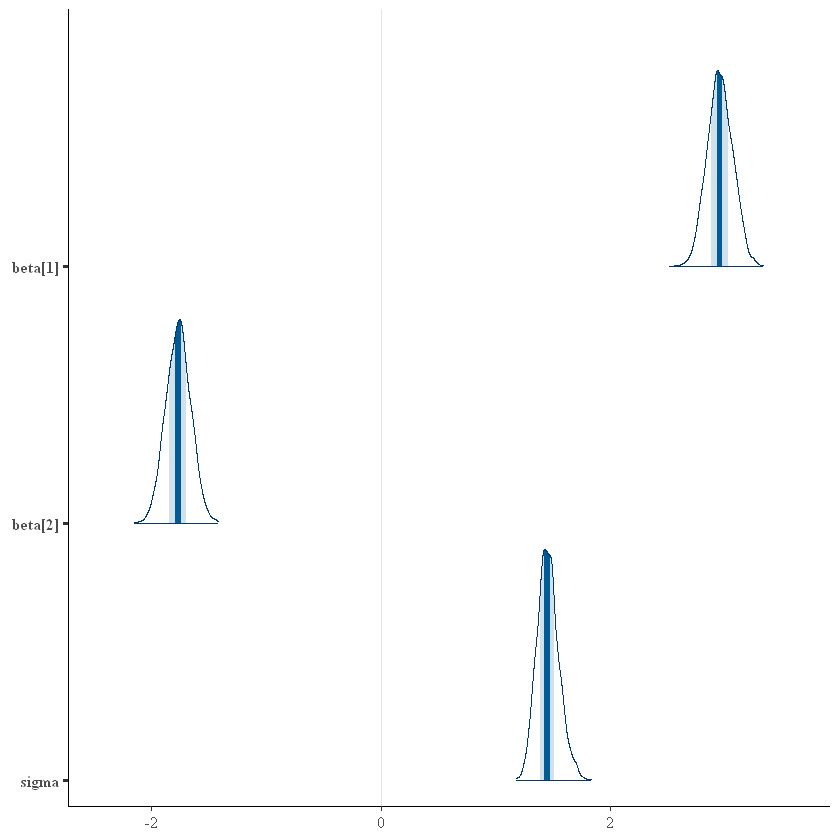

In [83]:
mcmc_areas(as.array(fit), pars = c("beta[1]", "beta[2]", "sigma"))

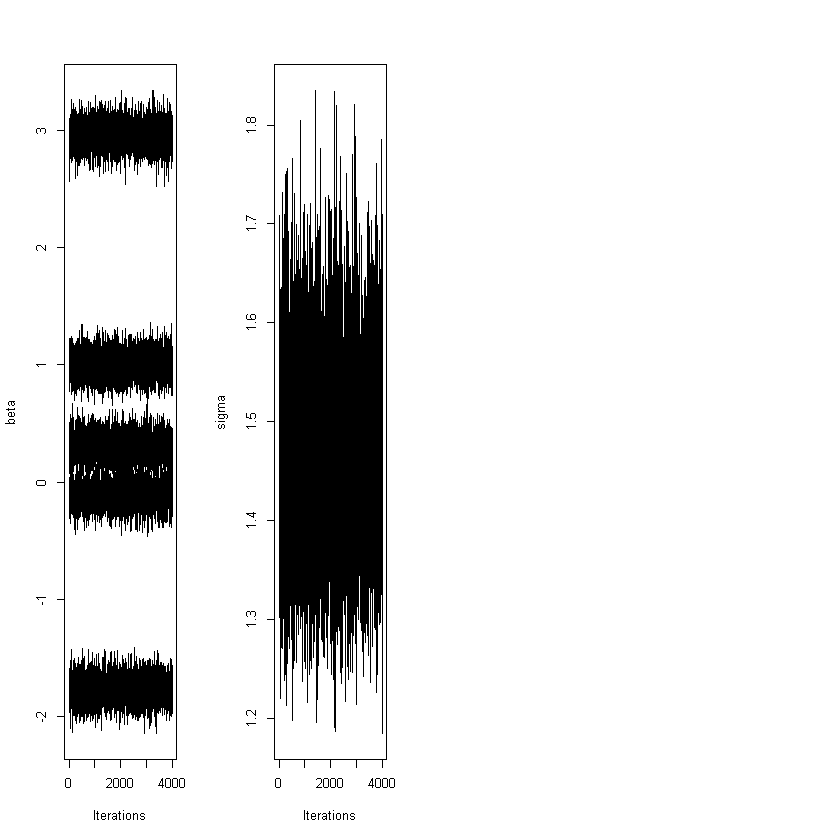

In [60]:
par(mfrow=c(1,4))
ts.plot(params$beta,xlab="Iterations",ylab="beta")
ts.plot(params$sigma,xlab="Iterations",ylab="sigma")

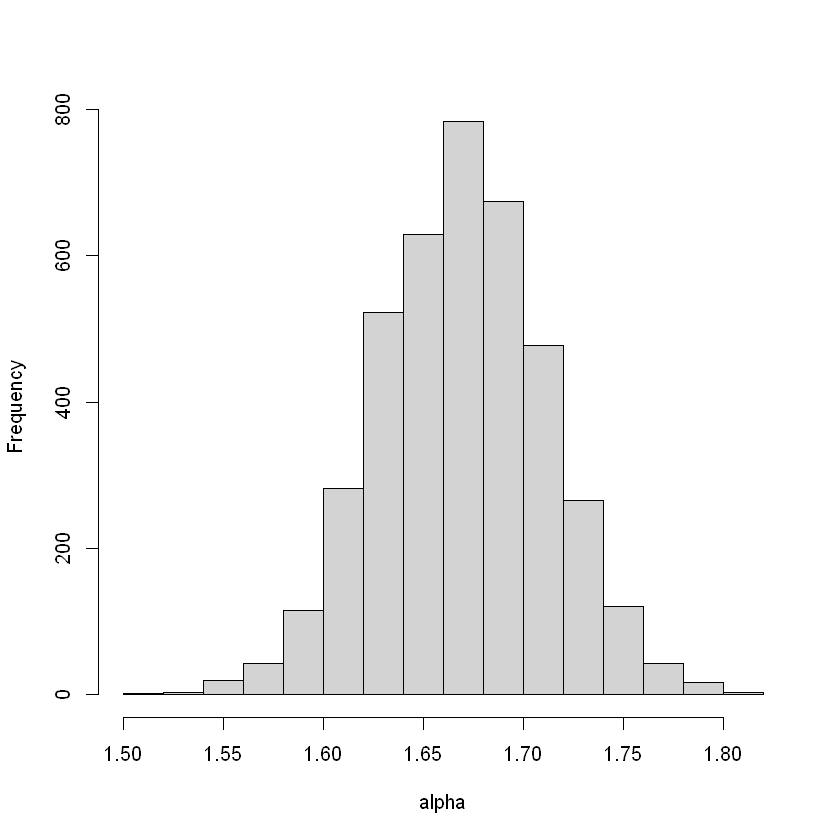

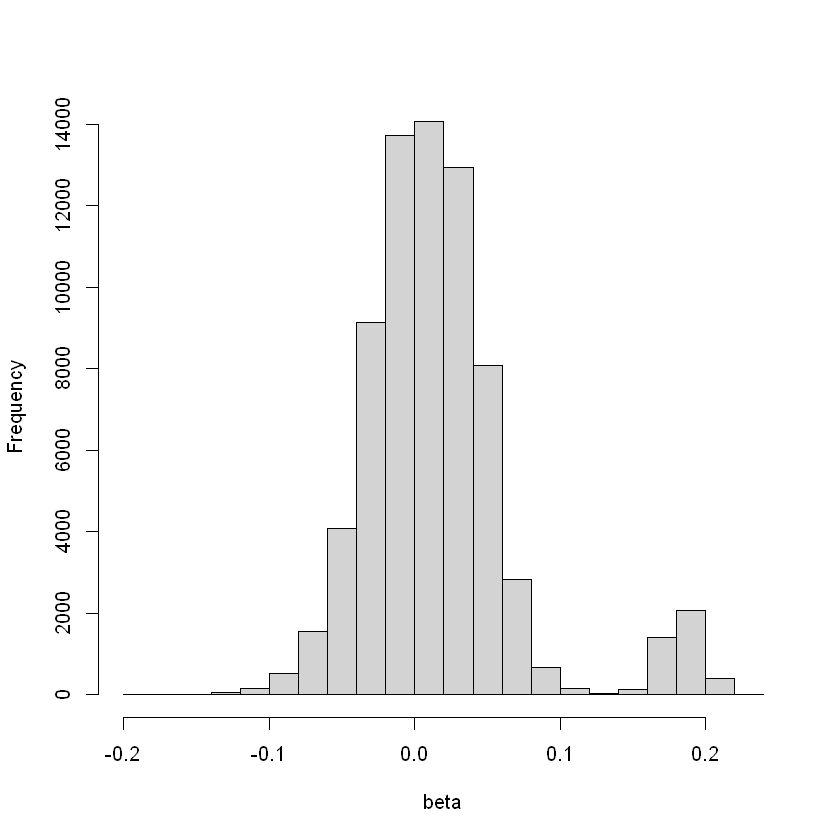

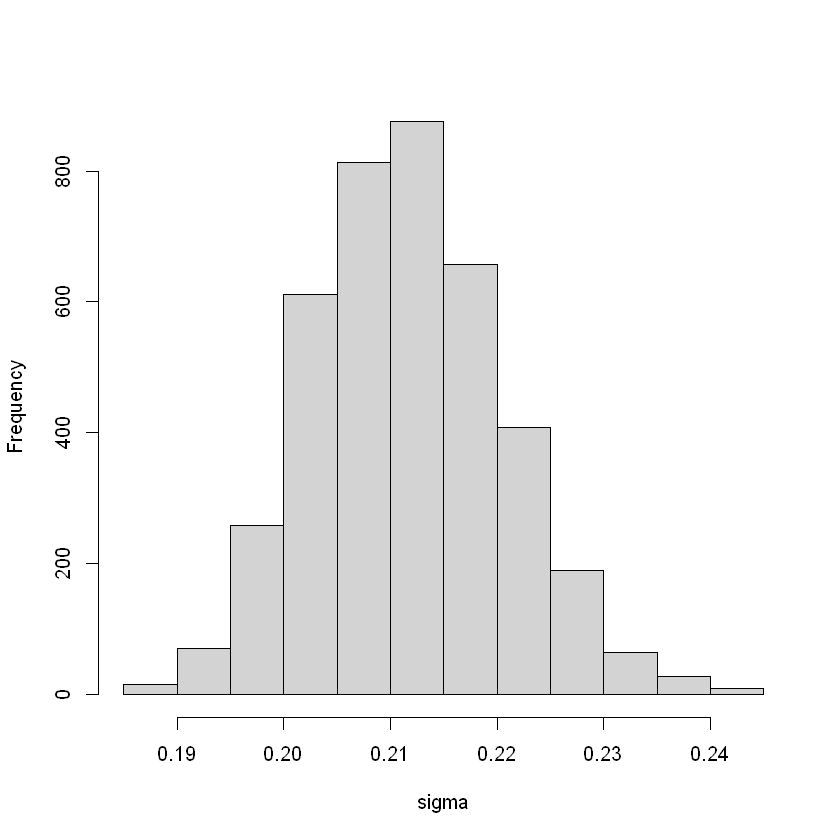

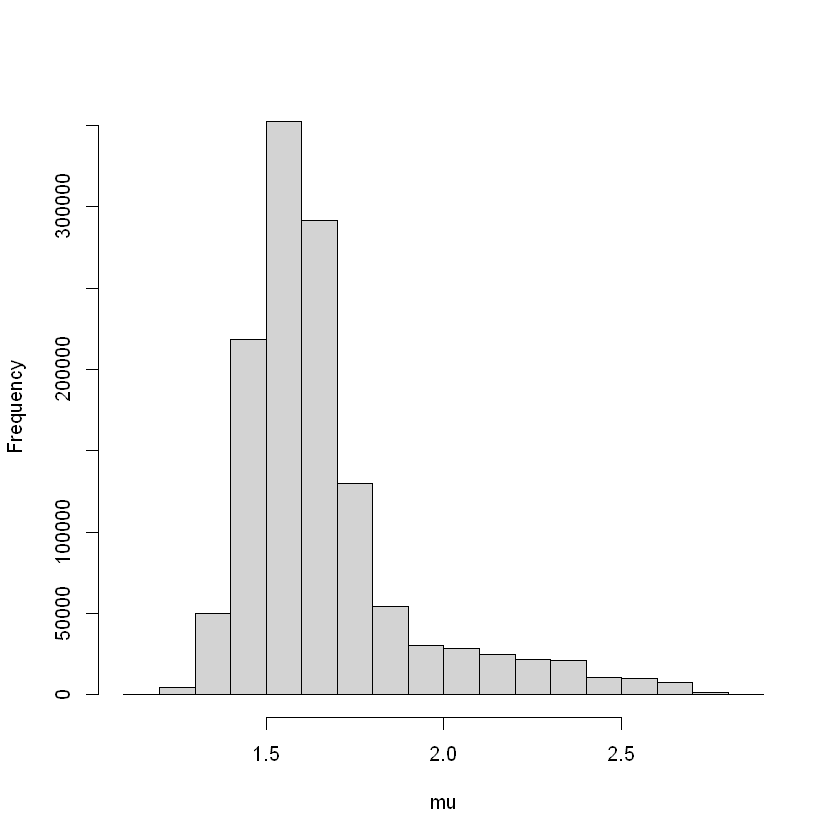

In [130]:
hist(params$beta,main="",xlab="beta")
hist(params$sigma,main="",xlab="sigma")

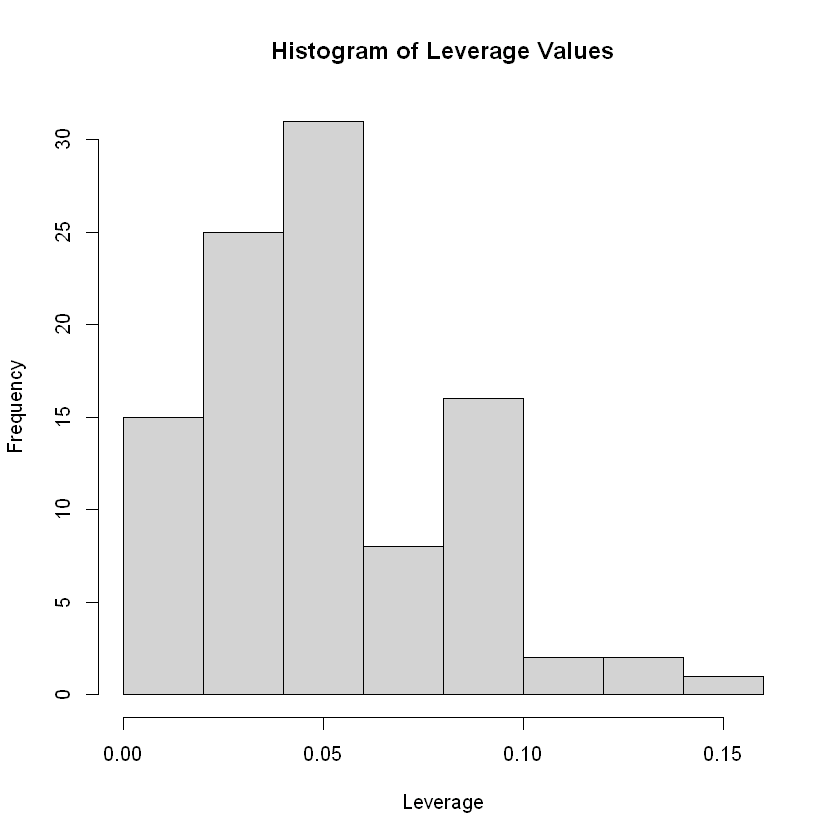

In [84]:

hat_matrix <- posterior_means[grep("^Hg", rownames(summary(fit)$summary))]

hat_matrix <- matrix(hat_matrix, nrow = N, ncol = N)

leverage <- diag(hat_matrix)
hist(leverage, main = "Histogram of Leverage Values", xlab = "Leverage")


### Now with diabetes Data

In [111]:
X.train <- as.matrix(X.train); y.train <- as.matrix(y.train); X.test <- as.matrix(X.test)
s20 <- mean((y.test - X.test %*% solve(t(X.train) %*% X.train) %*% t(X.train) %*% y.train)^2)
n <- g <- length(y.train); p <- ncol(X.train); nu0 <- 1; S <- 1000

Hg <- g/(g+1) * X.train%*%solve(t(X.train)%*%X.train) %*% t(X.train) 
SSRg <- t(y.train) %*% (diag(1,nrow = n) - Hg) %*% y.train

s2 <- 1/rgamma(S, (nu0+n)/2, (nu0*s20+SSRg)/2)

Vb <- g*solve(t(X.train)%*%X.train)/(g+1)
Eb <- Vb%*%t(X.train)%*%y.train

E <- matrix(rnorm(S*p, 0, sqrt(s2)), S, p)
beta <- t( t(E%*%chol(Vb)) + c(Eb))

In [120]:
as.data.frame(beta)

chol,stab.glu,hdl,ratio,age,height,weight,bp.1s,bp.1d,bp.2s,bp.2d,waist,hip,time.ppn,location_Louisa,gender_female,frame_medium,frame_large
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.034046612,0.1507960,-0.090358426,-3.581079e-02,0.049819008,0.4061343,-0.007213222,0.040726296,0.0383123211,-0.0004896397,-0.084231821,-0.001728194,-0.2870556,0.009757063,0.3017304,1.2709824,0.7458624,1.0977115
0.027031714,0.2066008,-0.011221389,1.035845e-02,0.052966161,0.3684130,-0.056997042,0.024073728,0.0163305257,0.0014670876,-0.088564945,-0.005810022,-0.2592442,0.017350369,0.4484275,1.0974365,0.8431922,1.1096712
-0.038969273,0.1785247,-0.033273653,1.924591e-02,0.039514127,0.3393064,0.008821147,0.010405580,0.0592423991,0.0041666283,-0.045112002,-0.050092096,-0.2100620,0.010073644,0.4182737,1.0301032,0.7704967,1.2603454
-0.058046190,0.1989526,0.027048609,4.556496e-02,0.030117802,0.2907705,0.146312556,0.131043656,-0.0309961219,-0.1240112144,-0.022703647,0.013295240,-0.3959503,-0.029371803,0.4400574,1.1911376,0.7892339,0.9183884
-0.022455101,0.2042227,0.033731640,4.454378e-02,0.082180511,0.4064073,0.005532867,0.009725552,0.0441411621,0.0028839579,-0.115321850,-0.027520847,-0.2327381,0.033055609,0.3937088,1.1141485,0.8671113,1.1065167
0.007955317,0.1833298,-0.065472209,-6.209704e-02,0.158665166,0.3212749,0.075678895,-0.080614980,0.0561221129,-0.0302020528,-0.109341666,-0.046811685,-0.3251736,0.016316852,0.3808665,1.0737163,0.8870982,1.1552805
-0.041167714,0.1801129,0.033988883,6.416654e-02,0.048705207,0.3748586,-0.166578402,0.056491078,-0.0410139506,0.0429132134,-0.024117354,0.136797039,-0.1952808,0.082570150,0.4844933,1.0463948,0.7943280,1.1251141
0.073797066,0.1988246,-0.076219198,-9.074593e-02,0.023876310,0.3473483,0.036988880,0.094631223,-0.1118546201,0.0163476198,-0.055219701,0.027689685,-0.2972626,0.090460171,0.5796591,1.0740809,0.7142036,1.0199264
-0.032023776,0.2019936,0.024417679,8.760895e-02,0.084344674,0.3426178,0.178611726,0.069789722,0.0407075972,-0.0190326097,-0.122692421,-0.199768349,-0.2540004,0.050197041,0.3648913,1.1526923,0.7089637,1.1408114


In [126]:
beta.estimates <- as.data.frame(beta) %>%
  summarise(across(
    everything(),
    list(
      mean = mean,
      `2.5%` = ~ quantile(.x, 0.025),
      `97.5%` = ~ quantile(.x, 0.975)
    ),
    .names = "{.col}_{.fn}"
  )) %>%
  pivot_longer(
    cols = everything(),
    names_to = "name",
    values_to = "value"
  ) %>%
  separate(
    col = name,
    into = c("beta", "stat"),
    sep = "_(?=[^_]+$)"
  ) %>%
  pivot_wider(
    names_from = stat,
    values_from = value
  ) %>%
  column_to_rownames(var = "beta")


In [127]:
beta.estimates

,mean,2.5%,97.5%
,<dbl>,<dbl>,<dbl>
chol,0.017672075,-0.10576309,0.13411469
stab.glu,0.182919709,0.11825524,0.25102591
hdl,-0.018797368,-0.16780512,0.11645629
ratio,0.002699158,-0.15253703,0.14501061
age,0.057172361,-0.02317216,0.13450316
height,0.352215156,0.27573222,0.43505770
weight,0.022973290,-0.15019643,0.18211368
bp.1s,0.018378338,-0.08568232,0.12673263
bp.1d,0.010337071,-0.08317854,0.09843596


In [130]:
beta.estimates <- beta.estimates %>%
  rownames_to_column(var = "beta") %>%
  mutate(significant = ifelse(`2.5%` > 0 | `97.5%` < 0, "Significant", "Not Significant"))

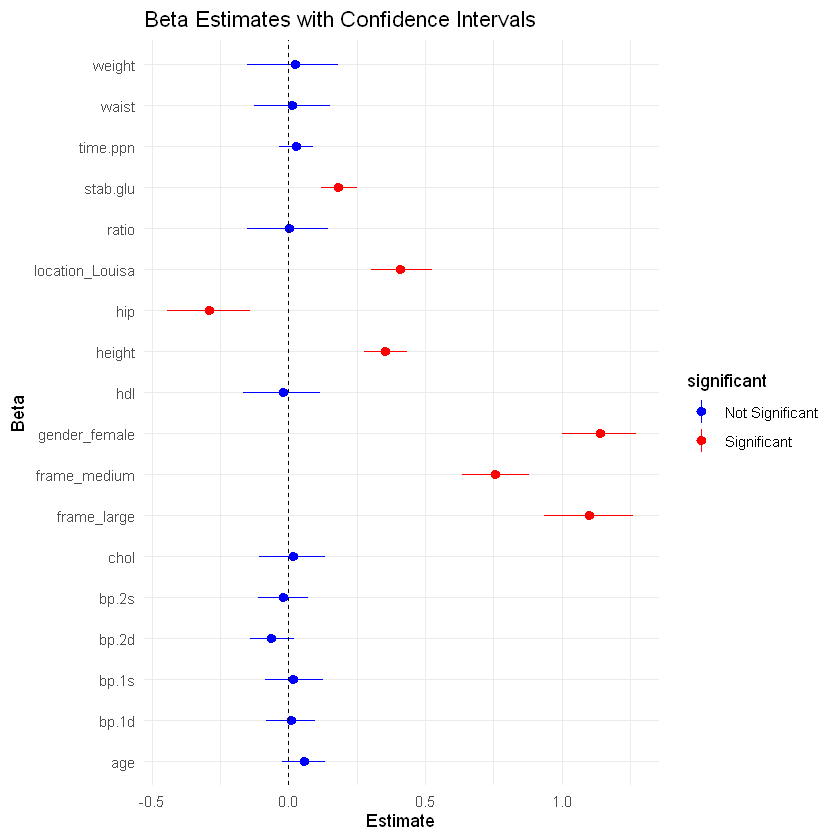

In [142]:
beta.est.plot <- ggplot(beta.estimates, aes(x = beta, y = mean, ymin = `2.5%`, ymax = `97.5%`, color = significant)) +
  geom_pointrange() +
  geom_hline(yintercept = 0, linetype = "dashed") +
  labs(title = "Beta Estimates with Confidence Intervals",
       x = "Beta",
       y = "Estimate") +
  theme_minimal() +
  scale_color_manual(values = c("Significant" = "red", "Not Significant" = "blue")) + coord_flip()
beta.est.plot

In [143]:
ggsave("betaEstimatesGPrior.png", plot = beta.est.plot)

Saving 7 x 7 in image


In [135]:
B <- as.matrix(beta.estimates$mean, nrow=nrow(beta.estimates), ncol=1)

In [139]:
y.hat.bayes <- X.test %*% B

In [140]:
exp(mean((y.hat.bayes - y.test)^2))

[1] 1.242054

## Model Selection

In [21]:
tau2 <- as.numeric(var(y.train) / mean(apply(X.train, 2, var)))
as.numeric(tau2)

[1] 0.1183338

In [22]:
data_list <- list(
  N = nrow(X.train),               # Number of observations
  P = ncol(X.train),                 # Number of predictors
  X = X.train, # Random design matrix (replace with your data)
  y = as.vector(y.train),        # Response variable (replace with your data)
  sigma2 = as.numeric(var(y.train)),            # Fixed variance for likelihood
  tau2 = tau2,              # Variance of slab for coefficients
  p_prior = 0.5          # Prior inclusion probability
)

In [23]:
fit <- stan(file = "gpriorLM.stan", data = data_list, seed = 42, chains = 4)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 7.6e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.76 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.672 seconds (Warm-up)
Chain 1:                0.404 seconds (Sampling)
Chain 1:                2.07

Warning message:
"There were 210 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


In [26]:
fit

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                       mean se_mean   sd    2.5%     25%     50%     75%
beta[1]                0.01     0.0 0.02   -0.02    0.00    0.01    0.02
beta[2]                0.18     0.0 0.02    0.14    0.17    0.18    0.19
beta[3]                0.00     0.0 0.02   -0.04   -0.02    0.00    0.01
beta[4]                0.02     0.0 0.02   -0.02    0.00    0.01    0.03
beta[5]                0.04     0.0 0.02    0.00    0.03    0.04    0.06
beta[6]                0.34     0.0 0.02    0.29    0.32    0.34    0.35
beta[7]                0.00     0.0 0.02   -0.05   -0.01    0.00    0.01
beta[8]                0.01     0.0 0.02   -0.02    0.00    0.01    0.03
beta[9]                0.00     0.0 0.02   -0.03   -0.01    0.00    0.01
beta[10]              -0.01     0.0 0.02   -0.05   -0.02   -0.01    0.00
beta[11]              -0.05     0.0 0.02 